# Plagiarism Detection Model

---

## Load Data to S3


In [1]:
import pandas as pd
import boto3
import sagemaker

In [2]:
# session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# create an S3 bucket
bucket = sagemaker_session.default_bucket()

In [3]:
# should be the name of directory you created to save your features data
data_dir = 'plagiarism_data'

# set prefix, a descriptive name for a directory  
prefix = 'sagemaker/plagiarism_detection'

# upload all data to S3

input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)

---

# Modeling


The type of model you create is up to you. For a binary classification task, you can choose to go one of three routes:
* Use a built-in classification algorithm, like LinearLearner.
* Define a custom Scikit-learn classifier, a comparison of models can be found [here](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html).
* Define a custom PyTorch neural network classifier. 

It will be up to you to test out a variety of models and choose the best one. Your project will be graded on the accuracy of your final model. 
 
---

## Implement Custom Classifier

To implement a custom classifier, you'll need to complete a `train.py` script. You've been given the folders `source_sklearn` and `source_pytorch` which hold starting code for a custom Scikit-learn model and a PyTorch model, respectively. Each directory has a `train.py` training script. To complete this project **you only need to complete one of these scripts**; the script that is responsible for training your final model.

A typical training script:
* Loads training data from a specified directory
* Parses any training & model hyperparameters (ex. nodes in a neural network, training epochs, etc.)
* Instantiates a model of your design, with any specified hyperparams
* Trains that model 
* Finally, saves the model so that it can be hosted/deployed, later


## Define a Scikit-learn  Estimator

In [6]:
from sagemaker.sklearn.estimator import SKLearn

estimator = SKLearn(entry_point='train.py', 
                   source_dir='source_sklearn',
                   role=role,
                   train_instance_count=1,
                   train_instance_type='ml.c4.xlarge')


This is not the latest supported version. If you would like to use version 0.23-1, please add framework_version=0.23-1 to your constructor.


## Train the estimator

In [7]:
%%time

# Train your estimator on S3 training data

estimator.fit({'train' : input_data})

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2020-09-26 17:17:03 Starting - Starting the training job...
2020-09-26 17:17:05 Starting - Launching requested ML instances......
2020-09-26 17:18:19 Starting - Preparing the instances for training......
2020-09-26 17:19:08 Downloading - Downloading input data...
2020-09-26 17:19:58 Training - Training image download completed. Training in progress..2020-09-26 17:19:58,854 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2020-09-26 17:19:58,856 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-09-26 17:19:58,866 sagemaker_sklearn_container.training INFO     Invoking user training script.
2020-09-26 17:20:06,291 sagemaker-containers INFO     Module train does not provide a setup.py. 
Generating setup.py
2020-09-26 17:20:06,291 sagemaker-containers INFO     Generating setup.cfg
2020-09-26 17:20:06,291 sagemaker-containers INFO     Generating MANIFEST.in
2020-09-26 17:20:06,291 sagemaker-containers INFO     Installing mo

## Deploy the trained model


In [8]:
%%time

predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')


Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


---------------!CPU times: user 297 ms, sys: 4.01 ms, total: 301 ms
Wall time: 7min 32s


In [9]:
import os

# read in test data, assuming it is stored locally
test_data = pd.read_csv(os.path.join(data_dir, "test.csv"), header=None, names=None)

# labels are in the first column
test_y = test_data.iloc[:,0]
test_x = test_data.iloc[:,1:]

## Determine the accuracy of your model

**To pass this project, your model should get at least 90% test accuracy.**

In [10]:
# First: generate predicted, class labels
test_y_preds = predictor.predict(test_x)

# test that your model generates the correct number of labels
assert len(test_y_preds)==len(test_y), 'Unexpected number of predictions.'
print('Test passed!')

Test passed!


In [11]:
from sklearn.metrics import accuracy_score
# Second: calculate the test accuracy
accuracy = accuracy_score(test_y, test_y_preds)

print(accuracy)


## print out the array of predicted and true labels, if you want
print('\nPredicted class labels: ')
print(test_y_preds)
print('\nTrue class labels: ')
print(test_y.values)

0.96

Predicted class labels: 
[1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 0 1 0 1 1 0 0]

True class labels: 
[1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 1 0 1 1 0 0]


In [12]:
from sklearn.metrics import confusion_matrix

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['plagiarized', 'non-plagiarized'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


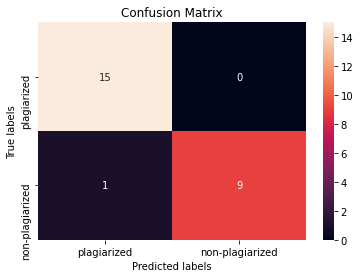

In [15]:
labels = ['plagiarized', 'non-plagiarized']
cm = confusion_matrix(np.where(test_y==1, 'plagiarized', 'non-plagiarized'),
                      np.where(test_y_preds==1, 'plagiarized', 'non-plagiarized'), labels)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(['plagiarized', 'non-plagiarized']);

In [14]:
tn, fp, fn, tp = confusion_matrix(test_y, test_y_preds).ravel()
print(f"""
         Number of false positives: {fp}
         Number of false negatives: {fn}""")


         Number of false positives: 1
         Number of false negatives: 0


### Question 1: How many false positives and false negatives did your model produce, if any? And why do you think this is?

**Answer**: 

The model produces only 1 false positive (predicting that the text was plagirized when it actually wasn't) and 0 false negative (predicting that it wasn't plagiarized when it actually was)

There may be several reasons why this happening:

- Our features correctly capture the differences between plagiarized and non-plagiarized responses, that is, both containtment and the normalized LCS have enough variation within our target variable to identify them.

- The choice of model may also be one of the reasons why this is happening. Below I'll discuss in detail, why I decided to use a Random Forest Classifier instead of a more complex model, but in a few words I chose this model mainly for 2 reasons: i) Amount of data available in the training set; ii) Model's ability to generalize (low-variance and low-bias).

### Question 2: How did you decide on the type of model to use? 

**Answer**:

The first criterion to decide which model to use was the amount of data available in the training set. From the feature engineering notebook, we know that we have 70 records available in the training set and decided to include only 4 low-correlated features. Given this, a neural network model wouldn't be the best choice as they usually require a large amount of data to learn the feature representation. Therefore, I decided to use "more simple" classifiers. 

The second criterion for model selection was ability to generalize, that is, I wanted a model that wouldn't overfit the data and at the same time provide a correct prediction. This is why I chose an ensemble model, in particular, tree-based ensembles like Random Forests have the ability to combine several decision trees with low-bias and high-variance into a low-bias and low-variance predictor.


In [16]:
estimator.delete_endpoint()

estimator.delete_endpoint() will be deprecated in SageMaker Python SDK v2. Please use the delete_endpoint() function on your predictor instead.
